### Image Intensity Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob


from pylab import rcParams

The data files we are starting with have the following structure. Each image has a .csv file with the total area of the image and the mean intensity, as well as a .csv file with the area of each ROI and the mean intensity of each ROI. <br><br>
The approach to processing there are two key measurements and one calculation: <br>
1. Whole image mean intensity
2. Total ROI mean intensity (mean of the mean intensity of all ROIs)
3. intensity = roi_mean_intensity / total_mean_intensity <br><br>

The master dataframe will need to have the following column headers:
- image_name
- series_number (x-axis)
- intensity (y-axis)
- channel (hue)
- sample (units)

**Creating a Master Dataframe**<br>
Process each file at one time and create a list holding the data that will eventuall represent every column, then create a dataframe with all the lists. 

In [2]:
directory = '/Volumes/ECD/pearson_microscopy_images'
l_h = ["low", "high"]
select_channel = ["cfp", "gfp", "cy5"]

# Lists that will eventually be the master dataframe columns
total_area = []
total_intensity = []
roi_area = []
roi_intensity = []
image_name = []
series_number = []
sample = []
channel = []
series_sample = []
l_or_h = []
first_frame_norm_intensity = []

for j in l_h:
    for i in range(2, 6):
        i = str(i)
        for c in select_channel:
            path = directory + "/" + j + "_t_spot" + i + "/" + c + "_results/*.csv"
            for f in glob.glob(path, recursive=True): 
                if "120" in f:
                    continue
                if f[-19:-14] == "total":
                    total_int = pd.read_csv(f)
                    area = total_int.iloc[0]["Area"]
                    mean_int = total_int.iloc[0]["Mean"]
                    total_intensity.append(mean_int)
                    total_area.append(area)
                if f[-17:-14] == "roi":
                    roi_int = pd.read_csv(f)
                    roi_a = roi_int["Area"].sum()
                    mean_int = roi_int["Mean"].mean()
                    roi_area.append(roi_a)
                    roi_intensity.append(mean_int)
                    # only add the following once (will be the same for total and roi files)
                    s_num = f[-20:-18]
                    if "t" in s_num:
                        s_num = s_num[-1]
                        add_zero = True
                    if s_num == '2' and add_zero is True:
                        first_frame_intensity = mean_int
                    ff_norm = mean_int / first_frame_intensity
                    first_frame_norm_intensity.append(ff_norm)
                    img_name = f[:-18] + ".TIF"
                    image_name.append(img_name)
                    series_number.append(s_num)
                    n_sample = j + "_" + i
                    sample.append(n_sample)
                    s_s = n_sample + "_" + c + "_" + s_num
                    if add_zero is True:
                        s_s = n_sample + "_" + c + "_0" + s_num  
                        add_zero = False
                    series_sample.append(s_s)
                    channel.append(c)
                    l_or_h.append(j)

a_roi_int = np.asarray(roi_intensity)
a_total_int = np.asarray(total_intensity)
norm_intensity = a_roi_int / a_total_int

dict_sample_intensities = {'image_name':image_name, 
                            'series_number':series_number, 
                            'sample':sample,
                            'l_or_h':l_or_h,
                            'channel':channel,
                            'series_sample':series_sample,
                            'roi_mean_intensity':roi_intensity,
                            'roi_area':roi_area,
                            'total_mean_intensity':total_intensity,
                            'total_area':total_area,
                            'norm_intensity':norm_intensity,
                            'first_frame_norm_intensity':first_frame_norm_intensity
                            }

In [3]:
master_data = pd.DataFrame(dict_sample_intensities)
#master_data.to_csv('/Volumes/ECD/pearson_microscopy_images/intensity_data_v2.csv', index=False)

### Smoothing the Trend Lines

In [3]:
# Import data
all_data = pd.read_csv('/Volumes/ECD/pearson_microscopy_images/intensity_data_v2.csv')

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing

##### Exponential Smoothing

In [23]:
spot_names = ['high_2', 'high_3', 'high_4', 'low_5', 'low_2', 'low_3', 'low_4', 'low_5']
channels = ['cfp', 'gfp', 'cy5']
fitted_dfs = []

for s in spot_names:
    for c in channels:
        df = all_data.loc[(all_data['sample'] == s) & (all_data['channel'] == c)].sort_values(by=['series_number']).reset_index()
        fit = ExponentialSmoothing(df['first_frame_norm_intensity'], initialization_method='estimated').fit(optimized=True)
        df['smoothed_intensity'] = fit.fittedvalues
        fitted_dfs.append(df)

smoothed_all_data = pd.concat(fitted_dfs)

In [45]:
high_df = None
low_df = None
highs = ['high_2', 'high_3', 'high_4', 'high_5']
cfps = []
gfps = []
cy5s = []

def get_sample_means(all_data, sample_types, all_samples=None):
    for s in sample_types:
        for c in channels:
            new_sample = all_data.loc[(all_data['sample'] == s) & (all_data['channel'] == c)].reset_index()
            vals_only = new_sample[['series_number', 'series_sample', 'first_frame_norm_intensity']].sort_values(by=['series_number']).reset_index()
            new_col_name = s + '_ff_norm_int'
            vals_only = vals_only.rename(columns={'first_frame_norm_intensity': new_col_name})
            if c == 'cfp':
                cfps.append(vals_only)
            if c == 'gfp':
                gfps.append(vals_only)
            if c == 'cy5':
                cy5s.append(vals_only)
    return cfps, gfps, cy5s


cfps, gfps, cy5s = get_sample_means(all_data, highs)



In [39]:
h_1 = all_data.loc[all_data['sample'] == 'high_2'].reset_index()

##### Locally Weighted Scatterplot Smoothing (LOWESS)

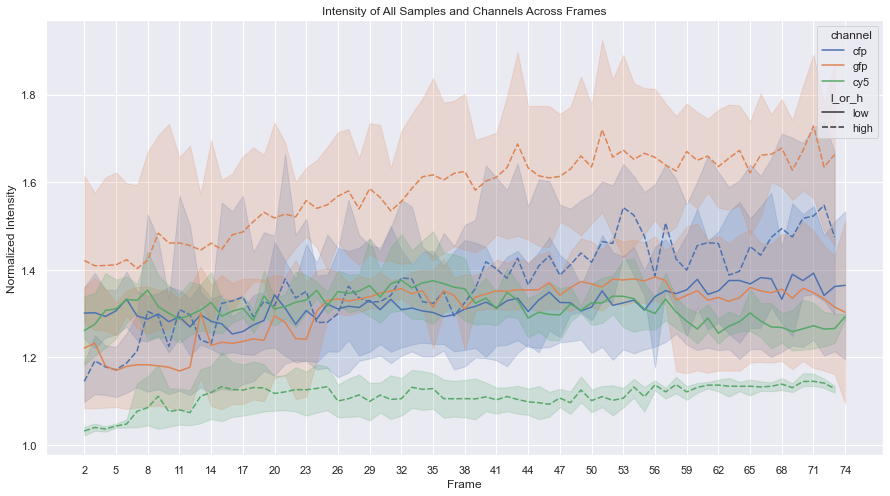

In [144]:
sns.set_style('darkgrid')
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=master_data, x="series_number", y="norm_intensity", hue='channel', style='l_or_h')
l.set(title='Intensity of All Samples and Channels Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/all_data.png', dpi=300, bbox_inches='tight')

/var/folders/f9/rr81cpfj7s38vm2zq1bv0j7r0000gn/T/ipykernel_95555/715596276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_spots[["series_number"]] = high_spots[["series_number"]].apply(pd.to_numeric)


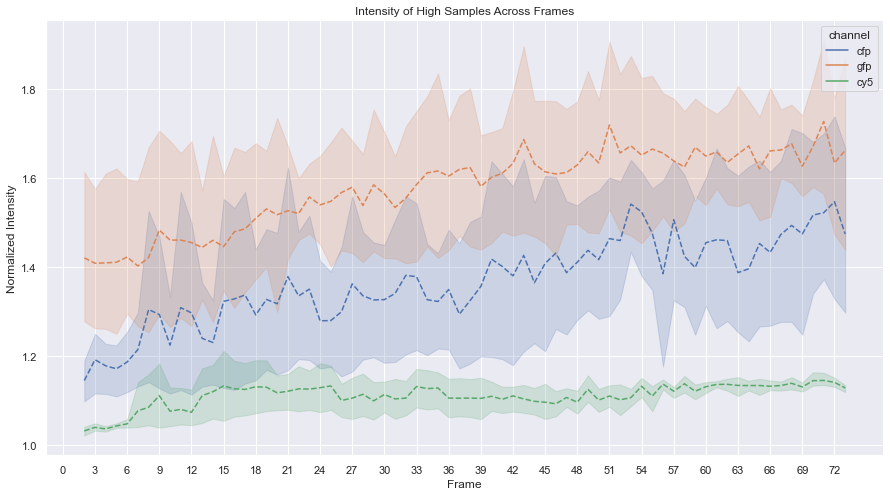

In [159]:
high_spots = master_data.loc[(master_data["l_or_h"]=='high')]
high_spots[["series_number"]] = high_spots[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=high_spots, x="series_number", y="norm_intensity", hue='channel', linestyle="dashed")
l.set(title='Intensity of High Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/high_samples.png', dpi=300, bbox_inches='tight')

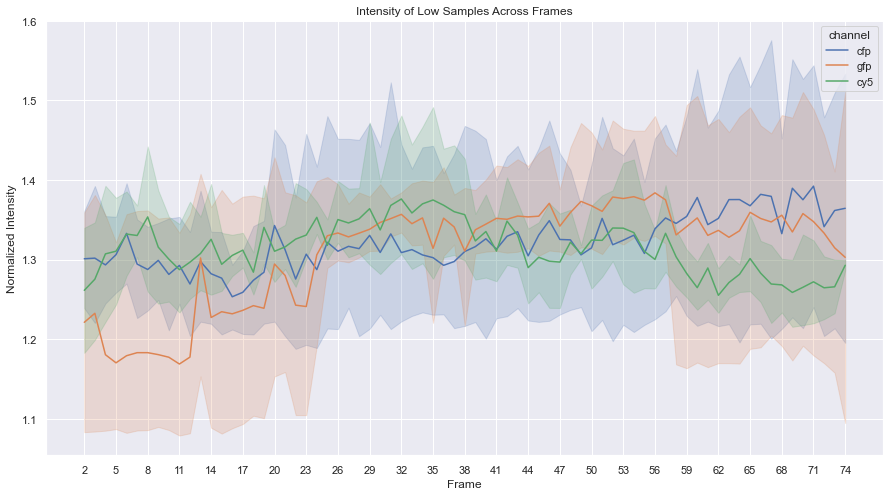

In [150]:
low_spots = master_data.loc[(master_data["l_or_h"]=='low')]
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=low_spots, x="series_number", y="norm_intensity", hue='channel')
l.set(title='Intensity of Low Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/plots/low_samples.png', dpi=300, bbox_inches='tight')

/var/folders/f9/rr81cpfj7s38vm2zq1bv0j7r0000gn/T/ipykernel_95555/2053480578.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_spots[["series_number"]] = high_spots[["series_number"]].apply(pd.to_numeric)


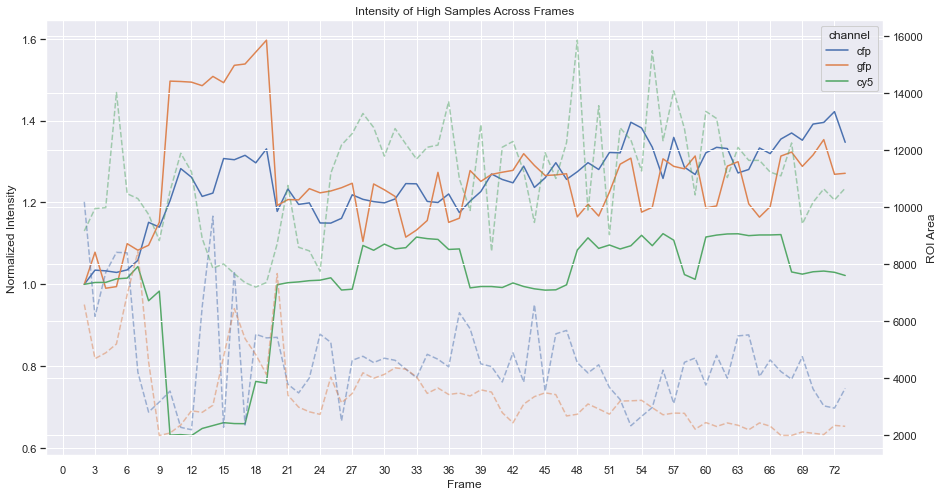

In [228]:
# High spots with First Frame Normalization and ROI Area
high_spots = master_data.loc[(master_data["l_or_h"]=='high')]
high_spots[["series_number"]] = high_spots[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=high_spots, x="series_number", y="first_frame_norm_intensity", hue='channel', errorbar=None)
ax2 = plt.twinx()
sns.lineplot(data=high_spots, x="series_number", y="roi_area", hue="channel", ax=ax2, errorbar=None, alpha=0.5, linestyle="dashed")
ax2.set_ylabel("ROI Area")
l.set(title='Intensity of High Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/high_ffnorm_samples.png', dpi=300, bbox_inches='tight')

/var/folders/f9/rr81cpfj7s38vm2zq1bv0j7r0000gn/T/ipykernel_95555/4255621488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_spots[["series_number"]] = low_spots[["series_number"]].apply(pd.to_numeric)


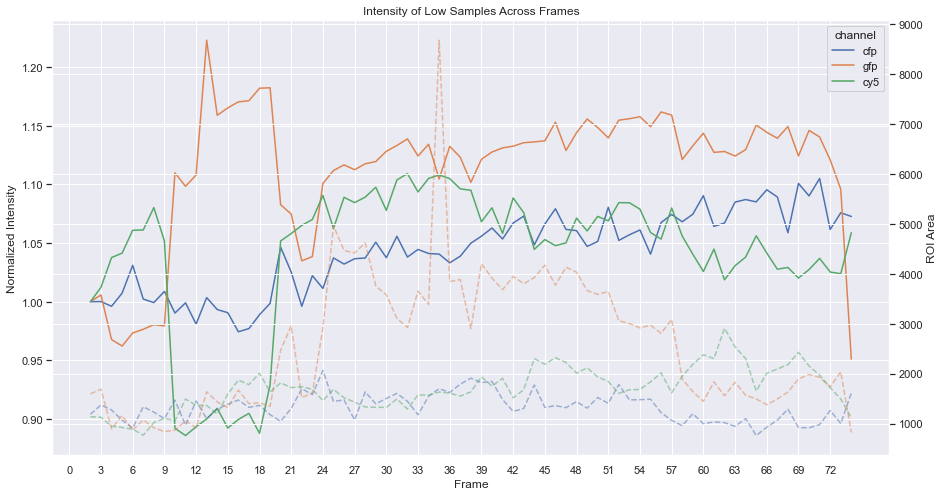

In [235]:
# Low spots with First Frame Normalization and ROI Area
low_spots = master_data.loc[(master_data["l_or_h"]=='low')]
low_spots[["series_number"]] = low_spots[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=low_spots, x="series_number", y="first_frame_norm_intensity", hue='channel', errorbar=None)
ax2 = plt.twinx()
sns.lineplot(data=low_spots, x="series_number", y="roi_area", hue="channel", ax=ax2, errorbar=None, alpha=0.5, linestyle="dashed")
ax2.set_ylabel("ROI Area")
l.set(title='Intensity of Low Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/low_ffnorm_samples.png', dpi=300, bbox_inches='tight')

/var/folders/f9/rr81cpfj7s38vm2zq1bv0j7r0000gn/T/ipykernel_23957/1096704677.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_spots[["series_number"]] = high_spots[["series_number"]].apply(pd.to_numeric)


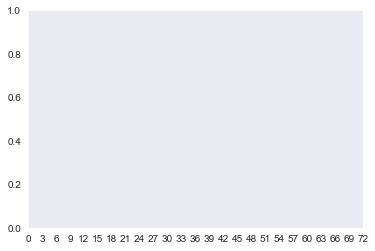

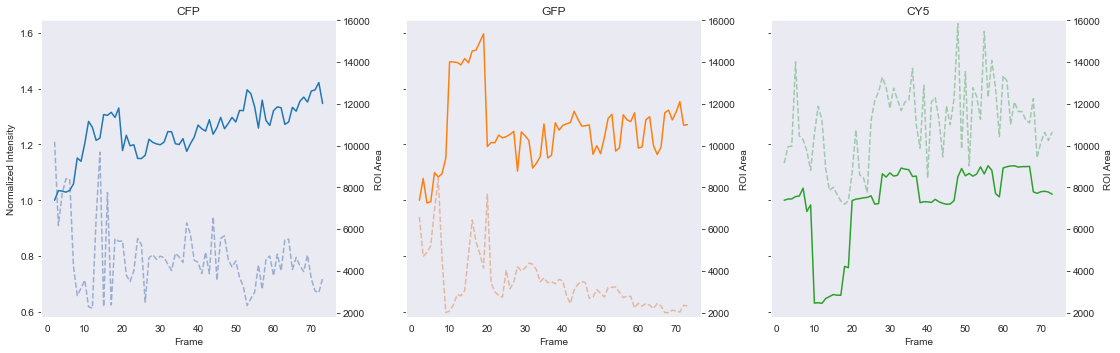

In [4]:
# Multi plot: High spots with First Frame Normalization and ROI Area
sns.set_style('dark')
high_spots = master_data.loc[(master_data["l_or_h"]=='high')]
high_spots[["series_number"]] = high_spots[["series_number"]].apply(pd.to_numeric)
#sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.relplot(data=high_spots, kind="line", x="series_number", y="first_frame_norm_intensity", col='channel', hue ='channel', errorbar=None, legend=False)
l.tight_layout(w_pad=7)
colors = ['#4c72b0','#dd8452','#55a868']
titles = ['CFP', 'GFP', 'CY5']
i=0
for channel, ax in l.axes_dict.items():
    ax2 = ax.twinx()
    h = sns.lineplot(data=high_spots[high_spots["channel"]==channel], x="series_number", linestyle="dashed", y="roi_area", alpha=0.5, ax=ax2, color=colors[i], errorbar=None)
    h.set(ylim=(1800, 16000))
    ax2.set_title(titles[i])
    i= i+1
    ax2.set_ylabel("ROI Area")
l.set(ylabel='Normalized Intensity', xlabel='Frame', title = '')
plt.savefig('/Volumes/ECD/pearson_microscopy_images/multi_plot_high.png', dpi=300, bbox_inches='tight')

/var/folders/f9/rr81cpfj7s38vm2zq1bv0j7r0000gn/T/ipykernel_23957/1056592016.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_spots[["series_number"]] = low_spots[["series_number"]].apply(pd.to_numeric)


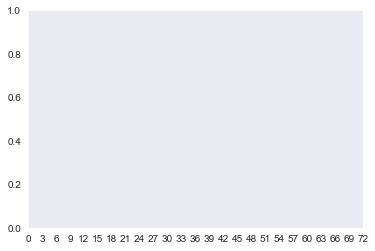

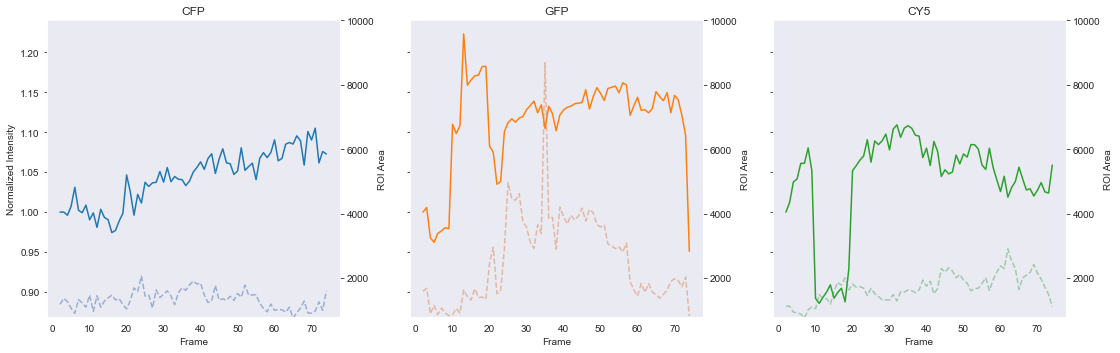

In [8]:
# Multi plot: Low spots with First Frame Normalization and ROI Area
sns.set_style('dark')
low_spots = master_data.loc[(master_data["l_or_h"]=='low')]
low_spots[["series_number"]] = low_spots[["series_number"]].apply(pd.to_numeric)
#sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.relplot(data=low_spots, kind="line", x="series_number", y="first_frame_norm_intensity", col='channel', hue ='channel', errorbar=None, legend=False)
l.tight_layout(w_pad=7)
colors = ['#4c72b0','#dd8452','#55a868']
titles = ['CFP', 'GFP', 'CY5']
i=0
for channel, ax in l.axes_dict.items():
    ax2 = ax.twinx()
    h = sns.lineplot(data=low_spots[low_spots["channel"]==channel], x="series_number", linestyle="dashed", y="roi_area", alpha=0.5, ax=ax2, color=colors[i], errorbar=None)
    h.set(ylim=(800, 10000))
    ax2.set_title(titles[i])
    i= i+1
    ax2.set_ylabel("ROI Area")
l.set(ylabel='Normalized Intensity', xlabel='Frame', title = '')
plt.savefig('/Volumes/ECD/pearson_microscopy_images/multi_plot_low.png', dpi=300, bbox_inches='tight')

In [209]:
p = sns.color_palette()
p.as_hex()[:]

['#4c72b0',
 '#dd8452',
 '#55a868',
 '#c44e52',
 '#8172b3',
 '#937860',
 '#da8bc3',
 '#8c8c8c',
 '#ccb974',
 '#64b5cd']

### New Data

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


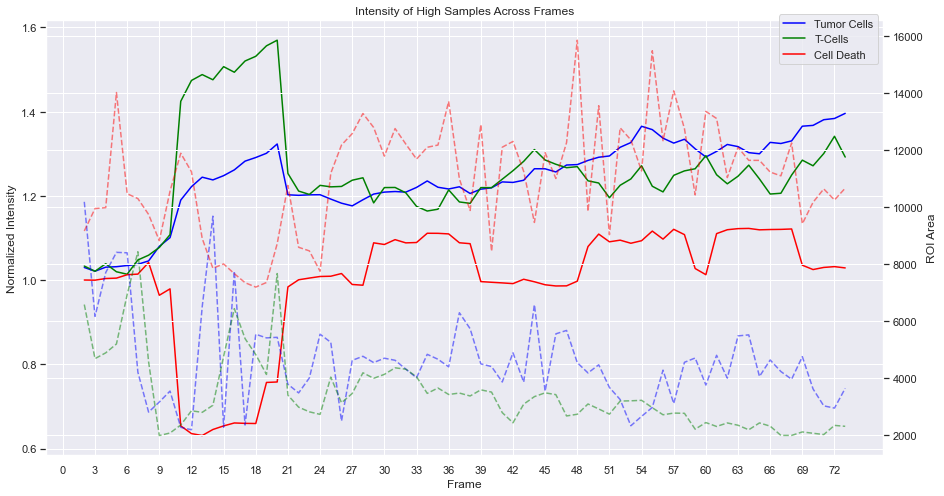

In [63]:
# High spots with First Frame Normalization and ROI Area
high_spots = smoothed_all_data.loc[(smoothed_all_data["l_or_h"]=='high')]
high_spots[["series_number"]] = high_spots[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=high_spots, x="series_number", y="smoothed_intensity", hue='channel', ci=None, palette=['blue', 'green', 'red'])
ax2 = plt.twinx()
plt.figlegend(labels=['Tumor Cells', 'T-Cells', 'Cell Death'], loc='upper right', bbox_to_anchor=(0.9,0.9))
sns.lineplot(data=high_spots, x="series_number", y="roi_area", hue="channel", ax=ax2, alpha=0.5, linestyle="dashed", ci=None, palette=['blue', 'green', 'red'])
ax2.set_ylabel("ROI Area")
l.set(title='Intensity of High Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
l.get_legend().remove()
ax2.get_legend().remove()
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/smoothed_high_ffnorm_samples.png', dpi=300, bbox_inches='tight')

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


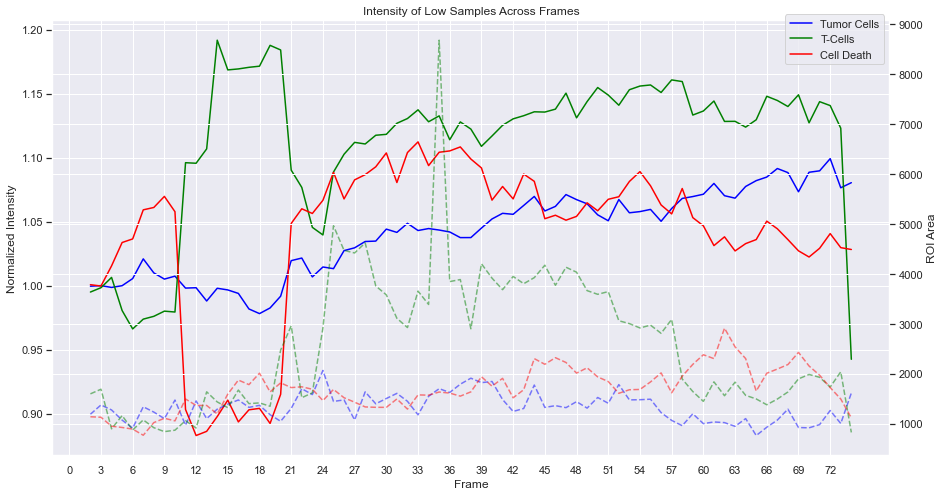

In [64]:
# Low spots with First Frame Normalization and ROI Area
high_spots = smoothed_all_data.loc[(smoothed_all_data["l_or_h"]=='low')]
high_spots[["series_number"]] = high_spots[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=high_spots, x="series_number", y="smoothed_intensity", hue='channel', ci=None, palette=['blue', 'green', 'red'])
ax2 = plt.twinx()
plt.figlegend(labels=['Tumor Cells', 'T-Cells', 'Cell Death'], loc='upper right', bbox_to_anchor=(0.9,0.9))
sns.lineplot(data=high_spots, x="series_number", y="roi_area", hue="channel", ax=ax2, alpha=0.5, linestyle="dashed", ci=None, palette=['blue', 'green', 'red'])
ax2.set_ylabel("ROI Area")
l.set(title='Intensity of Low Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
l.get_legend().remove()
ax2.get_legend().remove()
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/smoothed_low_ffnorm_samples.png', dpi=300, bbox_inches='tight')

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


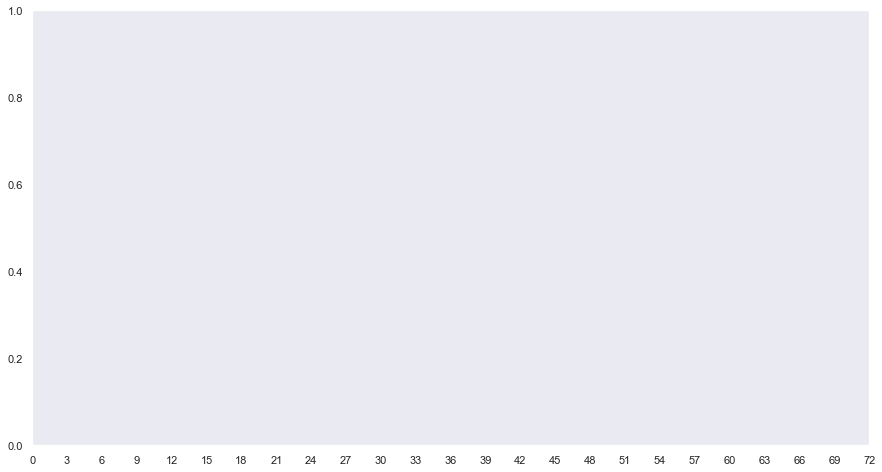

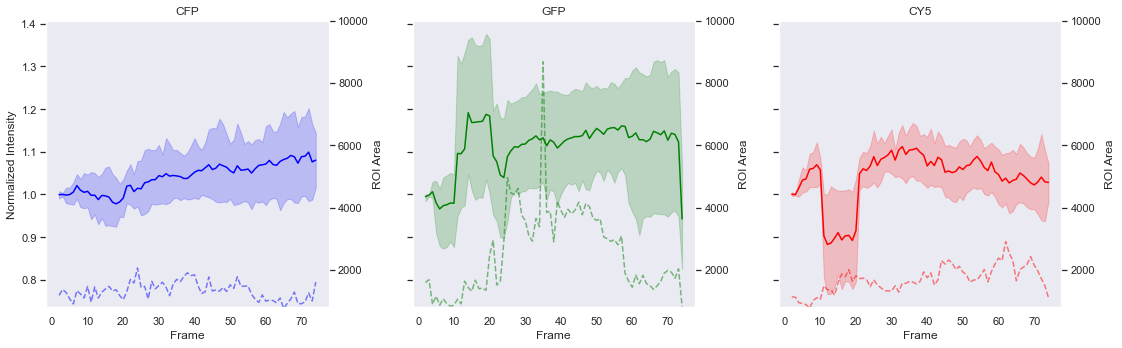

In [75]:
# Multi plot: Low spots with First Frame Normalization and ROI Area
sns.set_style('dark')
low_spots = smoothed_all_data.loc[(smoothed_all_data["l_or_h"]=='low')]
low_spots[["series_number"]] = low_spots[["series_number"]].apply(pd.to_numeric)
#sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.relplot(data=low_spots, kind="line", x="series_number", y="smoothed_intensity", col='channel', hue ='channel', legend=False, palette=['blue', 'green', 'red'])
l.tight_layout(w_pad=7)
colors = ['blue','green','red']
titles = ['CFP', 'GFP', 'CY5']
i=0
for channel, ax in l.axes_dict.items():
    ax2 = ax.twinx()
    h = sns.lineplot(data=low_spots[low_spots["channel"]==channel], x="series_number", linestyle="dashed", y="roi_area", alpha=0.5, ax=ax2, color=colors[i], ci=None)
    h.set(ylim=(800, 10000))
    ax2.set_title(titles[i])
    i= i+1
    ax2.set_ylabel("ROI Area")
l.set(ylabel='Normalized Intensity', xlabel='Frame', title = '')
plt.savefig('/Volumes/ECD/pearson_microscopy_images/smooth_multi_plot_low.png', dpi=300, bbox_inches='tight')

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


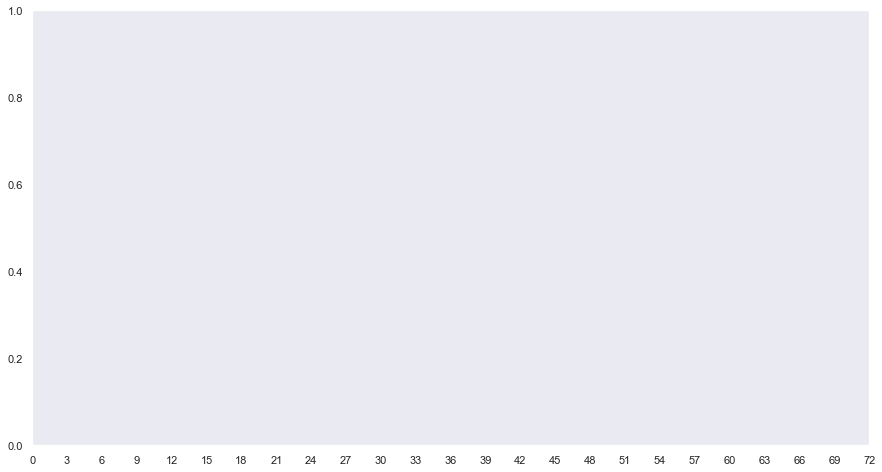

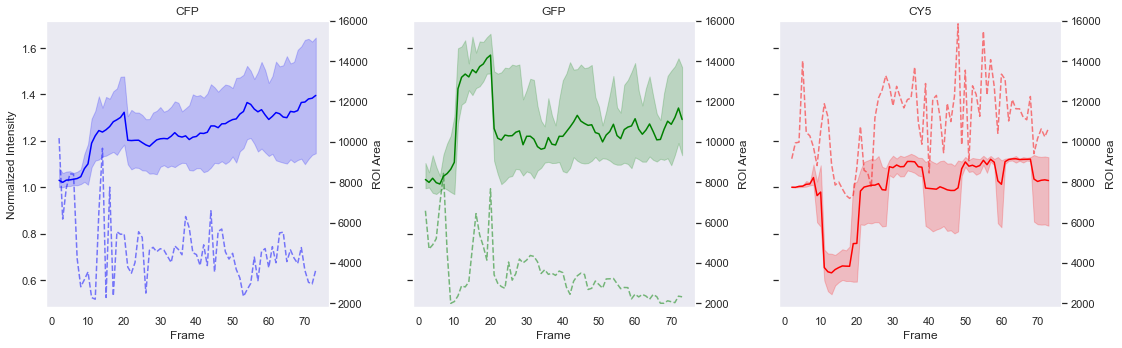

In [76]:
# Multi plot: High spots with First Frame Normalization and ROI Area
sns.set_style('dark')
high_spots = smoothed_all_data.loc[(smoothed_all_data["l_or_h"]=='high')]
high_spots[["series_number"]] = high_spots[["series_number"]].apply(pd.to_numeric)
#sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.relplot(data=high_spots, kind="line", x="series_number", y="smoothed_intensity", col='channel', hue ='channel', legend=False, palette=['blue','green','red'])
l.tight_layout(w_pad=7)
colors = ['blue','green','red']
titles = ['CFP', 'GFP', 'CY5']
i=0
for channel, ax in l.axes_dict.items():
    ax2 = ax.twinx()
    h = sns.lineplot(data=high_spots[high_spots["channel"]==channel], x="series_number", linestyle="dashed", y="roi_area", alpha=0.5, ax=ax2, color=colors[i], ci=None)
    h.set(ylim=(1800, 16000))
    ax2.set_title(titles[i])
    i= i+1
    ax2.set_ylabel("ROI Area")
l.set(ylabel='Normalized Intensity', xlabel='Frame', title = '')
plt.savefig('/Volumes/ECD/pearson_microscopy_images/smooth_multi_plot_high.png', dpi=300, bbox_inches='tight')

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


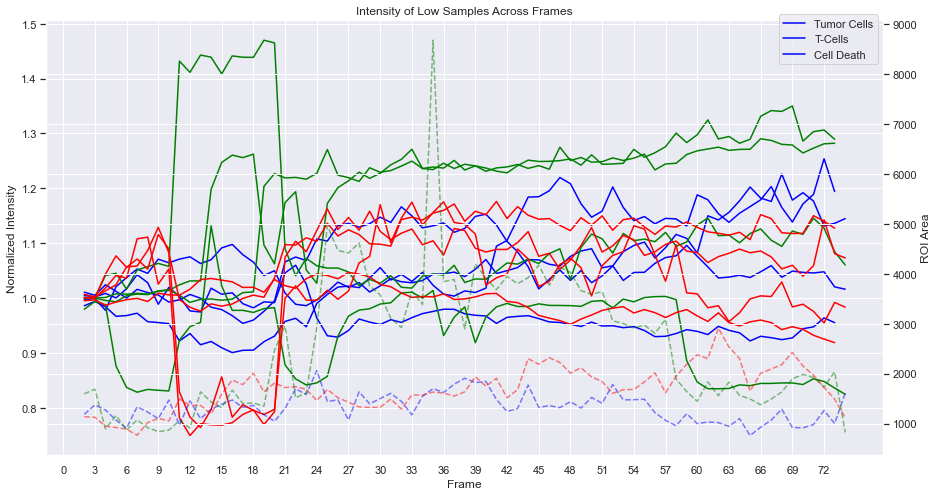

In [85]:
### Test
# Low spots with First Frame Normalization and ROI Area
high_spots = smoothed_all_data.loc[(smoothed_all_data["l_or_h"]=='low')]
high_spots[["series_number"]] = high_spots[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=high_spots, x="series_number", y="smoothed_intensity", hue='channel', estimator=None, units = 'sample', palette=['blue', 'green', 'red'])
ax2 = plt.twinx()
plt.figlegend(labels=['Tumor Cells', 'T-Cells', 'Cell Death'], loc='upper right', bbox_to_anchor=(0.9,0.9))
sns.lineplot(data=high_spots, x="series_number", y="roi_area", hue="channel", ax=ax2, alpha=0.5, linestyle="dashed", ci=None, palette=['blue', 'green', 'red'])
ax2.set_ylabel("ROI Area")
l.set(title='Intensity of Low Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
l.get_legend().remove()
ax2.get_legend().remove()
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/test_smoothed_low_ffnorm_samples.png', dpi=300, bbox_inches='tight')

In [ ]:
#### High Samples ####

#### CFP: Tumor Cells ####
cfp_high_samples = smoothed_all_data.loc[(smoothed_all_data['l_or_h'] == 'high') & (smoothed_all_data['channel']=='cfp')]
cfp_high_samples[["series_number"]] = cfp_high_samples[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=cfp_high_samples, x="series_number", y="smoothed_intensity", estimator=None, hue='sample')
l.set(title='Intensity of CFP High Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/cfp_high_samples.png', dpi=300, bbox_inches='tight')








/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


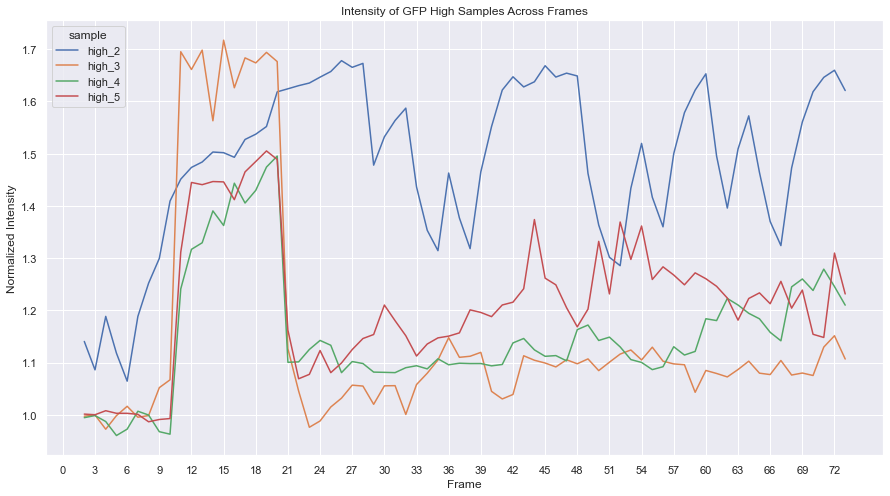

In [91]:
#### GFP: T-Cells ####
gfp_high_samples = smoothed_all_data.loc[(smoothed_all_data['l_or_h'] == 'high') & (smoothed_all_data['channel']=='gfp')]
gfp_high_samples[["series_number"]] = gfp_high_samples[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=gfp_high_samples, x="series_number", y="smoothed_intensity", estimator=None, hue='sample')
l.set(title='Intensity of GFP High Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/gfp_high_samples.png', dpi=300, bbox_inches='tight')


/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


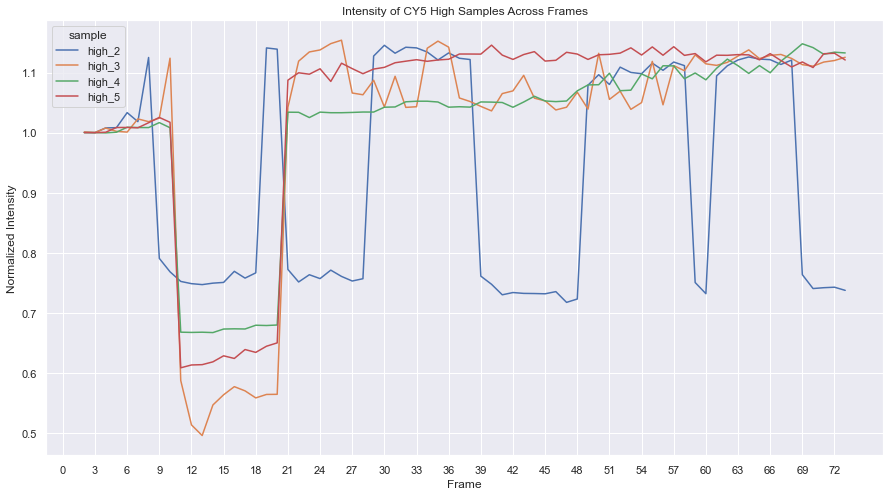

In [92]:
#### CY5: Cell Death ####
cy5_high_samples = smoothed_all_data.loc[(smoothed_all_data['l_or_h'] == 'high') & (smoothed_all_data['channel']=='cy5')]
cy5_high_samples[["series_number"]] = cy5_high_samples[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=cy5_high_samples, x="series_number", y="smoothed_intensity", estimator=None, hue='sample')
l.set(title='Intensity of CY5 High Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/cy5_high_samples.png', dpi=300, bbox_inches='tight')


/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


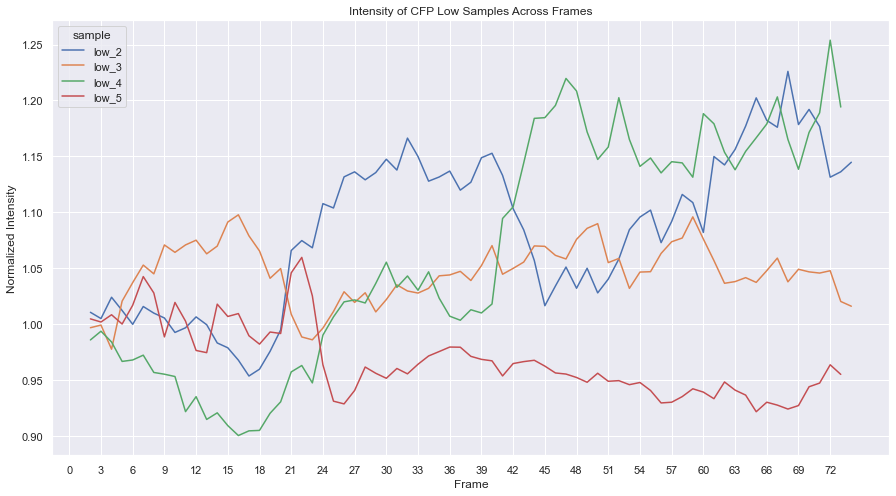

In [93]:
#### Low Samples ####

#### CFP: Tumor Cells ####
cfp_low_samples = smoothed_all_data.loc[(smoothed_all_data['l_or_h'] == 'low') & (smoothed_all_data['channel']=='cfp')]
cfp_low_samples[["series_number"]] = cfp_low_samples[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=cfp_low_samples, x="series_number", y="smoothed_intensity", estimator=None, hue='sample')
l.set(title='Intensity of CFP Low Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/cfp_low_samples.png', dpi=300, bbox_inches='tight')


/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


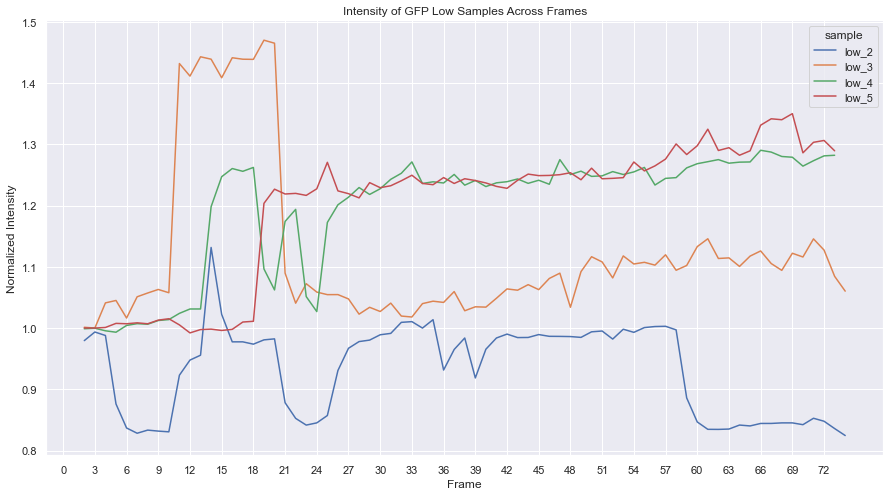

In [94]:
#### GFP: T-Cells ####
gfp_low_samples = smoothed_all_data.loc[(smoothed_all_data['l_or_h'] == 'low') & (smoothed_all_data['channel']=='gfp')]
gfp_low_samples[["series_number"]] = gfp_low_samples[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=gfp_low_samples, x="series_number", y="smoothed_intensity", estimator=None, hue='sample')
l.set(title='Intensity of GFP Low Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/gfp_low_samples.png', dpi=300, bbox_inches='tight')


/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


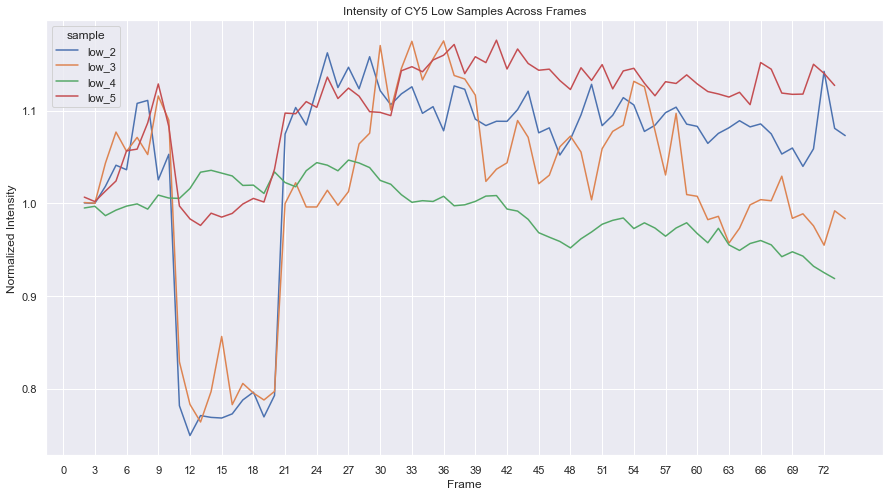

In [95]:
#### CY5: Cell Death ####
cy5_low_samples = smoothed_all_data.loc[(smoothed_all_data['l_or_h'] == 'low') & (smoothed_all_data['channel']=='cy5')]
cy5_low_samples[["series_number"]] = cy5_low_samples[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=cy5_low_samples, x="series_number", y="smoothed_intensity", estimator=None, hue='sample')
l.set(title='Intensity of CY5 Low Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/cy5_low_samples.png', dpi=300, bbox_inches='tight')
